## University of Cologne Partner Universities 2018 EDA

#### Overview
1. Introduction
2. Imports and setup
3. Scraping and wrangling the data
4. Exploratory data analysis
5. Geographical visualization

### 1. Introduction

In this small project I scrape the partner universities of the University of Cologne's Faculty of Management, Economics and Social Sciences as of August 2018. I also perform a short exploratory data analysis and create some visualizations. 

See the current list of partner universities here: https://www.international.wiso.uni-koeln.de/de/international-profile/partner-universities/

*Note: Because the URL has changed since the first creation of this notebook, there have been a couple of issues with retrieving the data correctly. I could already fix most issues, but a couple of European universities are currently missing in the analysis since they couldn't be extracted using the original code. I'll fix this issue asap.*

### 2. Imports and setup

In [1]:
# import libraries for data preparation, visualization and web scraping

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup
import html5lib

In [2]:
# import modules from visualization library for geographical plotting

import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [3]:
# settings for modules for visualization library for geographical plotting

init_notebook_mode(connected=True)

### 3. Scraping and wrangling the data

In [4]:
# get url where data is located

page = requests.get('https://www.international.wiso.uni-koeln.de/de/international-profile/partner-universities/')

In [5]:
# create soup object with raw html code

soup = BeautifulSoup(page.content,'html5lib')

In [6]:
# create lists to build key word lists to find relevant data in html code

numbers = [str(item) for item in range(1,7)]
region_id_1 = ['c189440_akkordeon_' for item in range (1,7)]
region_id_2 = ['-titel1' for item in range (1,7)]

In [7]:
# create list to find regions in soup object
# regions are located in html code at the following ids

region_ids = [id1+num+id2 for id1,num,id2 in zip(region_id_1,numbers,region_id_2)]
region_ids

['c189440_akkordeon_1-titel1',
 'c189440_akkordeon_2-titel1',
 'c189440_akkordeon_3-titel1',
 'c189440_akkordeon_4-titel1',
 'c189440_akkordeon_5-titel1',
 'c189440_akkordeon_6-titel1']

In [8]:
# create list to find countries and universities in soup object
# countries and universities are located in html code at the following ids

region_input_ids = [id1+num+'-1' for id1,num in zip(region_id_1,numbers)]
region_input_ids

['c189440_akkordeon_1-1',
 'c189440_akkordeon_2-1',
 'c189440_akkordeon_3-1',
 'c189440_akkordeon_4-1',
 'c189440_akkordeon_5-1',
 'c189440_akkordeon_6-1']

In [9]:
# find regions in html code

region_names = [soup.find(id=id).get_text().strip() for id in region_ids]
region_names

['Africa', 'Americas', 'Asia', 'Europe', 'Middle East', 'Oceania']

In [10]:
# create data frames from lists with region names, region ids and region input ids
# join data frames (will be used later to map regions and ids to countries and universities)

df_region_names = pd.DataFrame(region_names)
df_region_names.columns = ['Region']

df_region_ids = pd.DataFrame(region_ids)
df_region_ids.columns = ['Region IDs']

df_region_input_ids = pd.DataFrame(region_input_ids)
df_region_input_ids.columns = ['Region Input IDs']

df_region_names_ids = df_region_names.join(df_region_ids)
df_region_mapping = df_region_names_ids.join(df_region_input_ids)
df_region_mapping

,Region,Region IDs,Region Input IDs
0,Africa,c189440_akkordeon_1-titel1,c189440_akkordeon_1-1
1,Americas,c189440_akkordeon_2-titel1,c189440_akkordeon_2-1
2,Asia,c189440_akkordeon_3-titel1,c189440_akkordeon_3-1
3,Europe,c189440_akkordeon_4-titel1,c189440_akkordeon_4-1
4,Middle East,c189440_akkordeon_5-titel1,c189440_akkordeon_5-1
5,Oceania,c189440_akkordeon_6-titel1,c189440_akkordeon_6-1


In [11]:
# find countries (except for asian countries) in html code

countries = []

for id in region_input_ids:
    country_names = list(soup.find(id=id).find_all('b'))

    country_names = [str(item) for item in country_names]
    country_names = [re.sub('<b>','',item) for item in country_names]
    country_names = [re.sub('</b>','',item) for item in country_names]
    country_names = [re.sub('<br/>','',item) for item in country_names]
    country_names = [item+'split_here'+id for item in country_names]
    country_names = [item.split('split_here') for item in country_names]
    
    countries.extend(country_names)
    
countries

[['Egypt', 'c189440_akkordeon_1-1'],
 ['Ghana', 'c189440_akkordeon_1-1'],
 ['Senegal', 'c189440_akkordeon_1-1'],
 ['South Africa', 'c189440_akkordeon_1-1'],
 ['Argentina', 'c189440_akkordeon_2-1'],
 ['Brazil', 'c189440_akkordeon_2-1'],
 ['Canada', 'c189440_akkordeon_2-1'],
 ['Chile', 'c189440_akkordeon_2-1'],
 ['Mexico', 'c189440_akkordeon_2-1'],
 ['Peru', 'c189440_akkordeon_2-1'],
 ['USA', 'c189440_akkordeon_2-1'],
 ['Venezuela', 'c189440_akkordeon_2-1'],
 ['Austria', 'c189440_akkordeon_4-1'],
 ['Belgium', 'c189440_akkordeon_4-1'],
 ['Bulgaria', 'c189440_akkordeon_4-1'],
 ['Croatia', 'c189440_akkordeon_4-1'],
 ['Czech Republic', 'c189440_akkordeon_4-1'],
 ['Denmark', 'c189440_akkordeon_4-1'],
 ['Estonia', 'c189440_akkordeon_4-1'],
 ['Finland', 'c189440_akkordeon_4-1'],
 ['France', 'c189440_akkordeon_4-1'],
 ['Great Britain', 'c189440_akkordeon_4-1'],
 ['Greece', 'c189440_akkordeon_4-1'],
 ['Hungary', 'c189440_akkordeon_4-1'],
 ['Iceland', 'c189440_akkordeon_4-1'],
 ['Ireland', 'c18944

In [12]:
# find asian countries in html code (separate step required due to changes to the origin html code)

countries_asia = []

country_names_asia = list(soup.find(id='c189440_akkordeon_3-1').find_all('p'))

country_names_asia = [item.get_text('_') for item in country_names_asia]
country_names_asia = [item.split('_') for item in country_names_asia]

for item in [0, 2, 3, 4, 5, 6, 7, 8]:
    countries_asia.append(country_names_asia[item][0])

countries_asia = [item+'split_here'+'c189440_akkordeon_3-1' for item in countries_asia]
countries_asia = [item.split('split_here') for item in countries_asia]

countries_asia

[['China', 'c189440_akkordeon_3-1'],
 ['India', 'c189440_akkordeon_3-1'],
 ['Japan', 'c189440_akkordeon_3-1'],
 ['Philippines ', 'c189440_akkordeon_3-1'],
 ['Singapore ', 'c189440_akkordeon_3-1'],
 ['South Korea', 'c189440_akkordeon_3-1'],
 ['Taiwan', 'c189440_akkordeon_3-1'],
 ['Thailand', 'c189440_akkordeon_3-1']]

In [13]:
# add list of asian countries to list of all other countries

countries.extend(countries_asia)
countries

[['Egypt', 'c189440_akkordeon_1-1'],
 ['Ghana', 'c189440_akkordeon_1-1'],
 ['Senegal', 'c189440_akkordeon_1-1'],
 ['South Africa', 'c189440_akkordeon_1-1'],
 ['Argentina', 'c189440_akkordeon_2-1'],
 ['Brazil', 'c189440_akkordeon_2-1'],
 ['Canada', 'c189440_akkordeon_2-1'],
 ['Chile', 'c189440_akkordeon_2-1'],
 ['Mexico', 'c189440_akkordeon_2-1'],
 ['Peru', 'c189440_akkordeon_2-1'],
 ['USA', 'c189440_akkordeon_2-1'],
 ['Venezuela', 'c189440_akkordeon_2-1'],
 ['Austria', 'c189440_akkordeon_4-1'],
 ['Belgium', 'c189440_akkordeon_4-1'],
 ['Bulgaria', 'c189440_akkordeon_4-1'],
 ['Croatia', 'c189440_akkordeon_4-1'],
 ['Czech Republic', 'c189440_akkordeon_4-1'],
 ['Denmark', 'c189440_akkordeon_4-1'],
 ['Estonia', 'c189440_akkordeon_4-1'],
 ['Finland', 'c189440_akkordeon_4-1'],
 ['France', 'c189440_akkordeon_4-1'],
 ['Great Britain', 'c189440_akkordeon_4-1'],
 ['Greece', 'c189440_akkordeon_4-1'],
 ['Hungary', 'c189440_akkordeon_4-1'],
 ['Iceland', 'c189440_akkordeon_4-1'],
 ['Ireland', 'c18944

In [14]:
# create data frame from list with countries and region input ids

df_countries = pd.DataFrame(countries)
df_countries.columns = ['Country','Region Input IDs']
df_countries.head()

,Country,Region Input IDs
0,Egypt,c189440_akkordeon_1-1
1,Ghana,c189440_akkordeon_1-1
2,Senegal,c189440_akkordeon_1-1
3,South Africa,c189440_akkordeon_1-1
4,Argentina,c189440_akkordeon_2-1


In [15]:
# merge countries with regions and id mapping

df_region_country_mapping = pd.merge(df_countries,df_region_mapping,how='left',on='Region Input IDs')
df_region_country_mapping['Country'] = df_region_country_mapping['Country'].apply(lambda string: string.strip())
df_region_country_mapping.head()

,Country,Region Input IDs,Region,Region IDs
0,Egypt,c189440_akkordeon_1-1,Africa,c189440_akkordeon_1-titel1
1,Ghana,c189440_akkordeon_1-1,Africa,c189440_akkordeon_1-titel1
2,Senegal,c189440_akkordeon_1-1,Africa,c189440_akkordeon_1-titel1
3,South Africa,c189440_akkordeon_1-1,Africa,c189440_akkordeon_1-titel1
4,Argentina,c189440_akkordeon_2-1,Americas,c189440_akkordeon_2-titel1


In [16]:
# find countries and universities in html code

countries_universities = []

for id in region_input_ids:

    countries_universities_raw = list(soup.find(id=id).find_all('p'))
    
    countries_universities_raw = [item.get_text('_') for item in countries_universities_raw]
    countries_universities_raw = [item.split('_') for item in countries_universities_raw]
    
    countries_universities.extend(countries_universities_raw)
    
countries_universities

[['Egypt', 'The American University in Cairo'],
 ['Ghana', 'GIMPA – Ghana Institute of Management and Public Administration'],
 ['Senegal', 'Institut Africain de Management, Dakar'],
 ['South Africa',
  'University of Capetown, Graduate School of Business',
  'University of Stellenbosch Business School',
  'University of Witwatersrand, Wits Business School'],
 ['Argentina', 'Universidad Torcuato di Tella'],
 ['Brazil', 'Escola de Administracao de Empresas de Sao Paolo'],
 ['Canada',
  'Mc Gill University, Desautels Faculty of Management',
  'Université du Montréal à Quebec',
  'University of British Columbia, Sauder School of Business',
  'University of Calgary, Haskayne School of Business',
  'University of Victoria, Peter B. Gustavson School of Business',
  'The University of Western Ontario, Richard Ivey School of Business'],
 ['Chile',
  'Pontificia Universidad Católica de Chile',
  'Universidad Adolfo Ibáñez'],
 ['Mexico', 'ITAM – Instituto Tecnológico Autónomo de Mexico'],
 ['Per

In [17]:
# remove whitespace from list with countries and universities

for list in countries_universities:
    while ' ' in list: list.remove(' ')

In [18]:
# create data frame from list with countries and universities

df_countries_universities = pd.DataFrame(countries_universities)
df_countries_universities.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Egypt,The American University in Cairo,None,None,None,None,None,None,None,None,None,None,None
1,Ghana,GIMPA – Ghana Institute of Management and Publ...,None,None,None,None,None,None,None,None,None,None,None
2,Senegal,"Institut Africain de Management, Dakar",None,None,None,None,None,None,None,None,None,None,None
3,South Africa,"University of Capetown, Graduate School of Bus...",University of Stellenbosch Business School,"University of Witwatersrand, Wits Business School",None,None,None,None,None,None,None,None,None
4,Argentina,Universidad Torcuato di Tella,None,None,None,None,None,None,None,None,None,None,None


In [19]:
# transform and clean data frame from list with countries and universities

df_melt_countries_universities = pd.melt(df_countries_universities, id_vars=0)
df_melt_countries_universities = df_melt_countries_universities.dropna().drop(columns='variable')
df_melt_countries_universities.columns = ['Country','University']

df_final_countries_universities = df_melt_countries_universities.reset_index().drop(columns='index')
df_final_countries_universities['Country'] = df_final_countries_universities['Country'].apply(lambda string: string.strip())
df_final_countries_universities['University'] = df_final_countries_universities['University'].apply(lambda string: string.strip())
df_final_countries_universities.head()

,Country,University
0,Egypt,The American University in Cairo
1,Ghana,GIMPA – Ghana Institute of Management and Publ...
2,Senegal,"Institut Africain de Management, Dakar"
3,South Africa,"University of Capetown, Graduate School of Bus..."
4,Argentina,Universidad Torcuato di Tella


In [20]:
# merge countries and universities with region mapping

df_final_countries_universities_map = pd.merge(df_final_countries_universities,df_region_country_mapping,how='outer',on='Country')
df_final_countries_universities_map.drop(columns=['Region Input IDs','Region IDs'],inplace=True)
df_final_countries_universities_map.head()

,Country,University,Region
0,Egypt,The American University in Cairo,Africa
1,Ghana,GIMPA – Ghana Institute of Management and Publ...,Africa
2,Senegal,"Institut Africain de Management, Dakar",Africa
3,South Africa,"University of Capetown, Graduate School of Bus...",Africa
4,South Africa,University of Stellenbosch Business School,Africa


In [21]:
# universities in africa

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Africa']

,Country,University,Region
0,Egypt,The American University in Cairo,Africa
1,Ghana,GIMPA – Ghana Institute of Management and Publ...,Africa
2,Senegal,"Institut Africain de Management, Dakar",Africa
3,South Africa,"University of Capetown, Graduate School of Bus...",Africa
4,South Africa,University of Stellenbosch Business School,Africa
5,South Africa,"University of Witwatersrand, Wits Business School",Africa


In [22]:
# universities in the americas

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Americas']

,Country,University,Region
6,Argentina,Universidad Torcuato di Tella,Americas
7,Brazil,Escola de Administracao de Empresas de Sao Paolo,Americas
8,Canada,"Mc Gill University, Desautels Faculty of Manag...",Americas
9,Canada,Université du Montréal à Quebec,Americas
10,Canada,"University of British Columbia, Sauder School ...",Americas
11,Canada,"University of Calgary, Haskayne School of Busi...",Americas
12,Canada,"University of Victoria, Peter B. Gustavson Sch...",Americas
13,Canada,"The University of Western Ontario, Richard Ive...",Americas
14,Chile,Pontificia Universidad Católica de Chile,Americas
15,Chile,Universidad Adolfo Ibáñez,Americas


In [23]:
# universities in asia

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Asia']

,Country,University,Region
27,China,"Fudan University, School of Management",Asia
28,China,HKUST – Hongkong University of Science and Tec...,Asia
29,China,"Peking University, HSBC Business School",Asia
30,China,Shanghai University of Finance and Economics,Asia
31,China,"Sun Yat-Sen University, Sun Yat-Sen Business S...",Asia
32,China,"Tsinghua University, School of Economics und M...",Asia
33,China,UIBE – University of International Business an...,Asia
34,China,"The Chinese University of Hong Kong, Shenzhen",Asia
35,China,City University of Hong Kong,Asia
36,India,"Indian Institute of Management, Ahmedabad",Asia


In [24]:
# universities in europe

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Europe']

,Country,University,Region
53,Austria,Vienna University of Economics and Business,Europe
54,Belgium,KU Leuven,Europe
55,Belgium,"Université Catholique de Louvain, Louvain Scho...",Europe
56,Bulgaria,Sofia University Kliment Ohridski,Europe
57,Croatia,University of Zagreb,Europe
58,Czech Republic,Universitas Carolina Pragensis,Europe
59,Czech Republic,VSE – University of Economics Prague,Europe
60,Denmark,"Aarhus University, School of Business and Soci...",Europe
61,Denmark,Copenhagen Business School,Europe
62,Denmark,University of Copenhagen,Europe


In [25]:
# universities in the middle east

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Middle East']

,Country,University,Region
138,Israel,"University of Tel Aviv, Coller School of Manag...",Middle East


In [26]:
# universities in oceania

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Oceania']

,Country,University,Region
139,Australia,"The University of New South Wales, Australian ...",Oceania
140,Australia,"The University of Melbourne, Melbourne Busines...",Oceania
141,Australia,The University of Sydney Business School,Oceania
142,New Zealand,"University of Otago, Otago School of Business",Oceania


### 4. Exploratory data analysis and visualizations

In [27]:
# total number of universities

total_number_of_universities = df_final_countries_universities_map['University'].count()
print('Total number of universities: {}'.format(total_number_of_universities))

Total number of universities: 143


In [28]:
# number of universities per region

df_final_countries_universities_map['Region'].value_counts()

Europe         85
Asia           26
Americas       21
Africa          6
Oceania         4
Middle East     1
Name: Region, dtype: int64

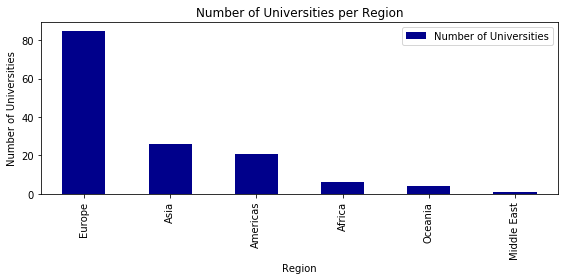

In [29]:
# histogram of universities per region

universities_per_region = pd.DataFrame(df_final_countries_universities_map['Region'].value_counts()).reset_index()
universities_per_region.columns = ['Region','Number of Universities']

universities_per_region.plot(x='Region',
                             y='Number of Universities',
                             kind='bar',
                             color='darkblue',
                             figsize=(8,4),
                             title='Number of Universities per Region')
plt.ylabel('Number of Universities')
plt.tight_layout()

In [30]:
# top 10 countries with most universities

df_final_countries_universities_map['Country'].value_counts().head(10)

France           12
Great Britain    11
China             9
USA               8
Spain             7
Canada            6
Italy             5
Turkey            5
Portugal          4
Ireland           4
Name: Country, dtype: int64

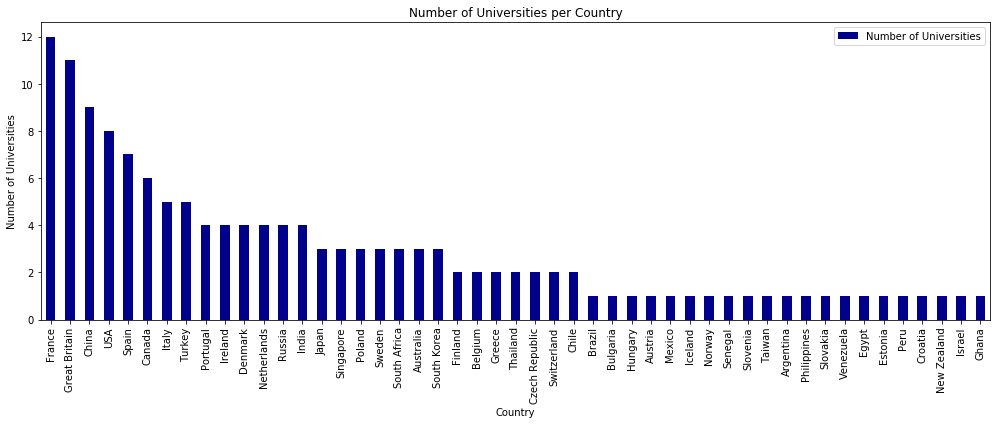

In [31]:
# histogram of universities per country

universities_per_country = pd.DataFrame(df_final_countries_universities_map['Country'].value_counts()).reset_index()
universities_per_country.columns = ['Country','Number of Universities']

universities_per_country.plot(x='Country',
                              y='Number of Universities',
                              kind='bar',
                              color='darkblue',
                              figsize=(14,6),
                              title='Number of Universities per Country')
plt.ylabel('Number of Universities')
plt.tight_layout()

### 5. Geographical visualization

In [32]:
# set up data and layout objects for geographical plot

data = dict(
        type = 'choropleth',
        colorscale = 'Blues',
        reversescale = True,
        locations = universities_per_country['Country'],
        locationmode = "country names",
        z = universities_per_country['Number of Universities'],
        text = universities_per_country['Country'],
        colorbar = {'title' : 'Universities'},
      ) 

layout = dict(title = 'Number of Universities per Country',
                geo = dict(showframe = False,projection = {'type':'Mercator'})
             )

In [33]:
# create choromap object with data and layout as inputs

choromap = go.Figure(data = [data],layout = layout)

In [34]:
# plot interactive choromap of universities and number of universities on world map

iplot(choromap)

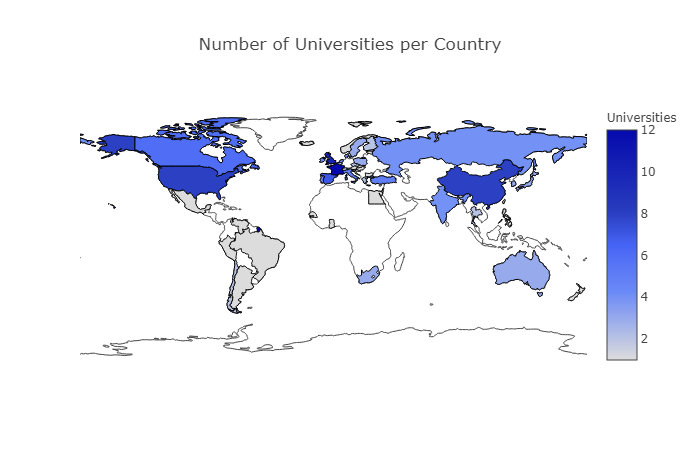

In [35]:
# the interactive choromap from above may be not directly visible in the Jupyter Notebook viewer on GitHub
# therefore I create a png file of the graph and include it below to get an idea of what the choromap shows

from IPython.display import Image
Image('universities per country world map.png')